In [16]:
import os,sys
import pickle
import xarray as xr
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
from shapely import wkt
from shapely.geometry import Point
#import cftime
from pathlib import Path
from tqdm import tqdm
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # For colormap
from matplotlib.lines import Line2D  # For custom legend
from matplotlib.colors import Normalize
from matplotlib.ticker import FuncFormatter, MultipleLocator,LinearLocator
import osm_flex.extract as ex
import igraph as ig
import networkx as nx
from rasterio.enums import Resampling
from exactextract import exact_extract
import matplotlib.patches as mpatches

import matplotlib.pyplot as plt
import contextily as cx
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

In [17]:
data_path = Path('input_files')
figure_path = Path('figures')
intermediate_path = Path('intermediate_results')
accessibility_analysis_path = Path('accessibility_analysis')

In [18]:
basins = pd.read_csv(intermediate_path / "SRB_flood_statistics_per_Basin_basins_scenario.csv")

all_basins = gpd.read_file(data_path / "hybas_eu_lev09_v1c.shp")
basins = gpd.GeoDataFrame(basins.merge(all_basins,left_on='basinID',right_on='HYBAS_ID'))


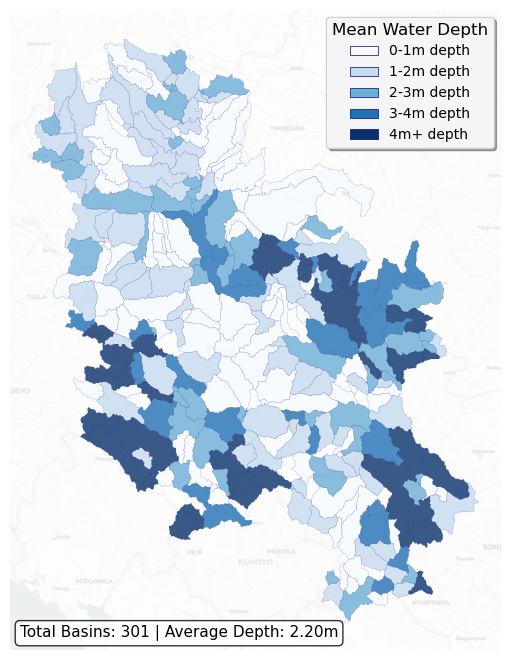

In [19]:
# Define bins for water depth data based on the histogram distribution
# Most basins are shallow (0-2m), with decreasing frequency toward deeper waters
bins = [0, 1, 2, 3, 4, np.inf]
labels = ['0-1m', '1-2m', '2-3m', '3-4m', '4m+']

# Create binned column
basins['depth_class'] = pd.cut(
    basins['mean water depth (m)'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)

# Create figure with high DPI for crisp visuals
fig, ax = plt.subplots(1, 1, figsize=(20, 8), facecolor='white')

# Create discrete colormap for water depth classes
# Using water/blue color palette from light to dark blue
colors = ['#f7fbff', '#c6dbef', '#6baed6', '#2171b5', '#08306b']
discrete_cmap = ListedColormap(colors)

# Convert to Web Mercator for plotting with basemap
basins_mercator = basins.to_crs(3857)

# Plot each water depth class with different colors
for i, (category, color) in enumerate(zip(labels, colors)):
    category_data = basins_mercator[basins_mercator['depth_class'] == category]
    
    if len(category_data) > 0:
        category_data.plot(
            ax=ax,
            color=color,
            linewidth=0.1,
            edgecolor='navy',
            alpha=0.8,
            legend=False
        )

# Add basemap with optimal styling for PNG
cx.add_basemap(
    ax=ax, 
    source=cx.providers.CartoDB.Positron, 
    alpha=0.4,
    attribution=False
)

# Enhance the plot styling
ax.set_aspect('equal')
ax.axis('off')  # Remove axis for cleaner look

# Create custom legend in upper right corner
legend_elements = [Patch(facecolor=colors[i], 
                        label=f'{labels[i]} depth', 
                        edgecolor='navy', 
                        linewidth=0.5) 
                  for i in range(len(labels))]

legend = ax.legend(handles=legend_elements, 
                  title='Mean Water Depth', 
                  loc='upper right',
                  fontsize=10,
                  title_fontsize=12,
                  frameon=True,
                  fancybox=True,
                  shadow=True,
                  framealpha=0.9,
                  facecolor='white',
                  edgecolor='#cccccc')

# Add subtitle with basin statistics
total_basins = len(basins)
mean_depth = basins['mean water depth (m)'].mean()
ax.text(0.02, 0.02, f'Total Basins: {total_basins:,} | Average Depth: {mean_depth:.2f}m', 
        transform=ax.transAxes, fontsize=11, 
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# Enhance overall plot appearance
plt.tight_layout()
plt.subplots_adjust(top=0.88, bottom=0.08, left=0.02, right=0.94)
plt.savefig(figure_path / 'basin_water_depths.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
base_network = gpd.read_parquet(intermediate_path / "base_network_SRB_basins.parquet")

edges = base_network.reindex(['from_id','to_id'] + [x for x in list(base_network.columns) if x not in ['from_id','to_id']],axis=1)
graph = ig.Graph.TupleList(edges.itertuples(index=False), edge_attrs=list(edges.columns)[2:],directed=True)
graph.vs['id'] = graph.vs['name']

graph = graph.connected_components().giant()
edges = edges[edges['id'].isin(graph.es['id'])]

In [21]:
base_network = base_network.to_crs(3857)

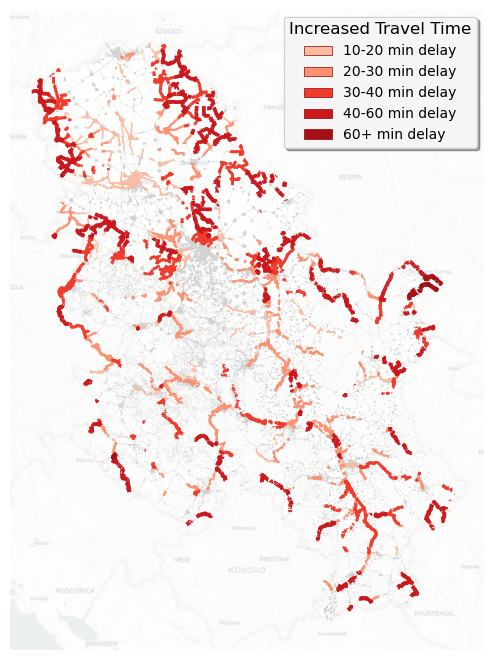

In [22]:
hospital_results_path = accessibility_analysis_path / "healthcare_criticality_results" / "save_new_results_SRB_basins.pkl"
hospital_basins = accessibility_analysis_path / "healthcare_criticality_results" / "unique_scenarios_SRB_basins.pkl"

with open(hospital_results_path, 'rb') as file:
    save_new_results = pickle.load(file)

with open(hospital_basins, 'rb') as file:
    save_new_basin_results = pickle.load(file)

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('future.no_silent_downcasting', True)
river_basins = list(save_new_results.keys())

collect_removed_edges = []

for basin in river_basins:
    scenario_outcome = save_new_results[basin]['scenario_outcome']
    subset_edges = base_network.loc[base_network.osm_id.astype(str).isin(save_new_results[basin]['real_edges_to_remove'])]
    subset_edges['travel_time_impact'] = scenario_outcome.loc[scenario_outcome.Delta > 0].replace([np.inf, -np.inf], 1).Delta.mean()

    collect_removed_edges.append(subset_edges)
exposed_edges = gpd.GeoDataFrame(pd.concat(collect_removed_edges))[['osm_id','from_id', 'to_id','highway','exposed','geometry','travel_time_impact']]

hospital_exposed_edges = exposed_edges.loc[exposed_edges.exposed == True].reset_index(drop=True).set_crs(3857,allow_override=True)

# Replace inf with a specific value and nan with 0
hospital_exposed_edges['travel_time_impact'] = np.where(
    np.isinf(hospital_exposed_edges['travel_time_impact']), 
    1,  # Replace inf with this value
    hospital_exposed_edges['travel_time_impact']
)

hospital_exposed_edges = hospital_exposed_edges.to_crs(3857)

# Filter out everything below 10 minutes (0.167 hours)
exposed_edges_filtered = exposed_edges[exposed_edges['travel_time_impact'] >= 0.167].copy().to_crs(3857)

# Define bins for travel time impact - 10-minute increments, ignoring <10 min
# 0.167 hrs = 10 min, 0.333 hrs = 20 min, 0.5 hrs = 30 min, 0.667 hrs = 40 min, 1.0 hrs = 60 min
bins = [0.167, 0.333, 0.5, 0.667, 1.0, np.inf]
labels = ['10-20 min', '20-30 min', '30-40 min', '40-60 min', '60+ min']

legend_elements = []

# Create binned column for travel time impact
exposed_edges_filtered['impact_class'] = pd.cut(
    exposed_edges_filtered['travel_time_impact'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)

# Create figure with high DPI for crisp visuals
fig, ax = plt.subplots(1, 1, figsize=(20, 8), facecolor='white')

# Create discrete colormap for travel time impact classes
# Using red/orange color scheme - light to dark (low to high impact)
colors = ['#fcbba1', '#fc9272', '#ef3b2c', '#cb181d', '#a50f15']
discrete_cmap = ListedColormap(colors)

# Define line widths for each category (higher impact = thicker lines)
width_mapping = {
    '10-20 min': 1,    # Low impact
    '20-30 min': 1.5,    # Medium-low impact
    '30-40 min': 2.0,    # Medium impact
    '40-60 min': 2.5,    # High impact
    '60+ min': 3       # Very high impact
}

# Plot baseline network first
base_network.plot(ax=ax, linewidth=0.1, color='lightgrey', alpha=0.5)

# Convert to Web Mercator for plotting with basemap
edges_mercator = exposed_edges_filtered.to_crs(3857)

# Plot each travel time impact class with different colors and widths
for i, (category, color) in enumerate(zip(labels, colors)):
    category_data = edges_mercator[edges_mercator['impact_class'] == category]
    
    if len(category_data) > 0:
        category_data.plot(
            ax=ax,
            color=color,
            linewidth=width_mapping[category],
            alpha=0.9,
            zorder=5 + i  # Higher impact roads on top
        )

# Add basemap with optimal styling for PNG
cx.add_basemap(
    ax=ax, 
    source=cx.providers.CartoDB.Positron, 
    alpha=0.4,
    attribution=False
)

# Enhance the plot styling
ax.set_aspect('equal')
ax.axis('off')  # Remove axis for cleaner look

# Create custom legend in upper right corner
legend_elements.extend([Patch(facecolor=colors[i], 
                             label=f'{labels[i]} delay', 
                             edgecolor='darkred', 
                             linewidth=0.5) 
                       for i in range(len(labels))])

legend = ax.legend(handles=legend_elements, 
                  title='Increased Travel Time', 
                  loc='upper right',
                  fontsize=10,
                  title_fontsize=12,
                  frameon=True,
                  fancybox=True,
                  shadow=True,
                  framealpha=0.9,
                  facecolor='white',
                  edgecolor='#cccccc')

plt.tight_layout()
plt.subplots_adjust(top=0.88, bottom=0.08, left=0.02, right=0.94)
plt.savefig(figure_path / 'hospital_criticality.png', dpi=200, bbox_inches='tight')
plt.show()

plt.close()

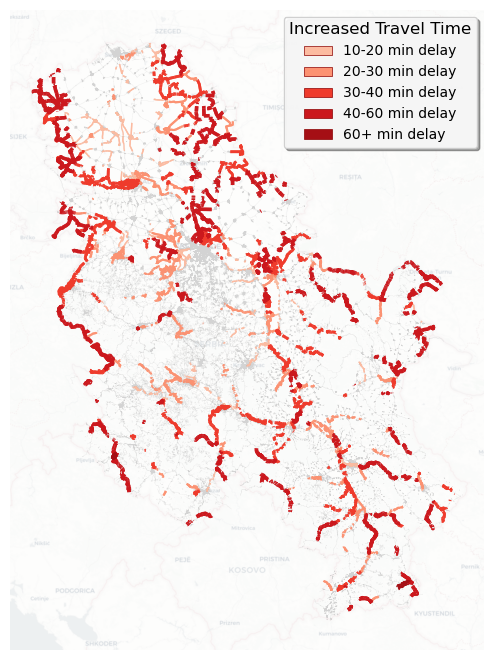

In [23]:
police_results_path = accessibility_analysis_path / "police_criticality_results" / "save_new_results_SRB_basins.pkl"
police_basins = accessibility_analysis_path / "police_criticality_results" / "unique_scenarios_SRB_basins.pkl"

with open(police_results_path, 'rb') as file:
    save_new_results = pickle.load(file)

with open(police_basins, 'rb') as file:
    save_new_basin_results = pickle.load(file)

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('future.no_silent_downcasting', True)
river_basins = list(save_new_results.keys())

collect_removed_edges = []

for basin in river_basins:
    scenario_outcome = save_new_results[basin]['scenario_outcome']
    subset_edges = base_network.loc[base_network.osm_id.astype(str).isin(save_new_results[basin]['real_edges_to_remove'])]
    subset_edges['travel_time_impact'] = scenario_outcome.loc[scenario_outcome.Delta > 0].replace([np.inf, -np.inf], 1).Delta.mean()

    collect_removed_edges.append(subset_edges)
exposed_edges = gpd.GeoDataFrame(pd.concat(collect_removed_edges))[['osm_id','from_id', 'to_id','highway','exposed','geometry','travel_time_impact']]

police_exposed_edges = exposed_edges.loc[exposed_edges.exposed == True].reset_index(drop=True).set_crs(3857,allow_override=True)

# Replace inf with a specific value and nan with 0
police_exposed_edges['travel_time_impact'] = np.where(
    np.isinf(police_exposed_edges['travel_time_impact']), 
    1,  # Replace inf with this value
    police_exposed_edges['travel_time_impact']
)

police_exposed_edges = police_exposed_edges.to_crs(3857)

# Filter out everything below 10 minutes (0.167 hours)
exposed_edges_filtered = exposed_edges[exposed_edges['travel_time_impact'] >= 0.167].copy().to_crs(3857)

# Define bins for travel time impact - 10-minute increments, ignoring <10 min
# 0.167 hrs = 10 min, 0.333 hrs = 20 min, 0.5 hrs = 30 min, 0.667 hrs = 40 min, 1.0 hrs = 60 min
bins = [0.167, 0.333, 0.5, 0.667, 1.0, np.inf]
labels = ['10-20 min', '20-30 min', '30-40 min', '40-60 min', '60+ min']

legend_elements = []

# Create binned column for travel time impact
exposed_edges_filtered['impact_class'] = pd.cut(
    exposed_edges_filtered['travel_time_impact'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)

# Create figure with high DPI for crisp visuals
fig, ax = plt.subplots(1, 1, figsize=(20, 8), facecolor='white')

# Create discrete colormap for travel time impact classes
# Using red/orange color scheme - light to dark (low to high impact)
colors = ['#fcbba1', '#fc9272', '#ef3b2c', '#cb181d', '#a50f15']
discrete_cmap = ListedColormap(colors)

# Define line widths for each category (higher impact = thicker lines)
width_mapping = {
    '10-20 min': 1,    # Low impact
    '20-30 min': 1.5,    # Medium-low impact
    '30-40 min': 2.0,    # Medium impact
    '40-60 min': 2.5,    # High impact
    '60+ min': 3       # Very high impact
}

# Plot baseline network first
base_network.plot(ax=ax, linewidth=0.1, color='lightgrey', alpha=0.5)

# Convert to Web Mercator for plotting with basemap
edges_mercator = exposed_edges_filtered.to_crs(3857)

# Plot each travel time impact class with different colors and widths
for i, (category, color) in enumerate(zip(labels, colors)):
    category_data = edges_mercator[edges_mercator['impact_class'] == category]
    
    if len(category_data) > 0:
        category_data.plot(
            ax=ax,
            color=color,
            linewidth=width_mapping[category],
            alpha=0.9,
            zorder=5 + i  # Higher impact roads on top
        )

# Add basemap with optimal styling for PNG
cx.add_basemap(
    ax=ax, 
    source=cx.providers.CartoDB.Positron, 
    alpha=0.4,
    attribution=False
)

# Enhance the plot styling
ax.set_aspect('equal')
ax.axis('off')  # Remove axis for cleaner look

# Create custom legend in upper right corner
legend_elements.extend([Patch(facecolor=colors[i], 
                             label=f'{labels[i]} delay', 
                             edgecolor='darkred', 
                             linewidth=0.5) 
                       for i in range(len(labels))])

legend = ax.legend(handles=legend_elements, 
                  title='Increased Travel Time', 
                  loc='upper right',
                  fontsize=10,
                  title_fontsize=12,
                  frameon=True,
                  fancybox=True,
                  shadow=True,
                  framealpha=0.9,
                  facecolor='white',
                  edgecolor='#cccccc')

plt.tight_layout()
plt.subplots_adjust(top=0.88, bottom=0.08, left=0.02, right=0.94)
plt.savefig(figure_path / 'police_criticality.png', dpi=200, bbox_inches='tight')
plt.show()

plt.close()

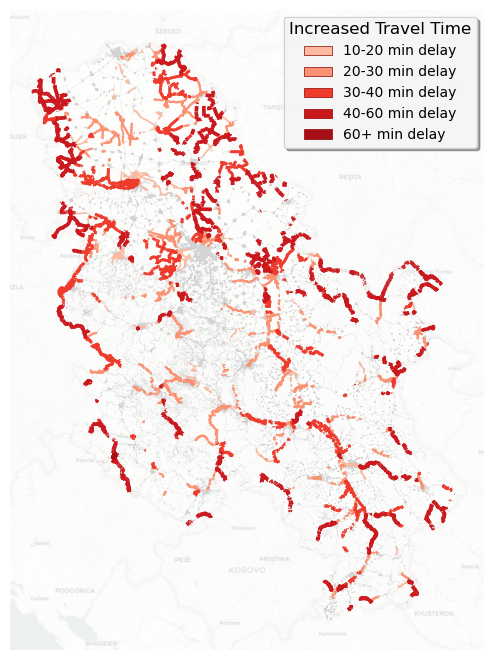

In [24]:
fire_results_path = accessibility_analysis_path / "fire_criticality_results" / "save_new_results_SRB_basins.pkl"
fire_basins = accessibility_analysis_path / "fire_criticality_results" / "unique_scenarios_SRB_basins.pkl"

with open(fire_results_path, 'rb') as file:
    save_new_results = pickle.load(file)

with open(fire_basins, 'rb') as file:
    save_new_basin_results = pickle.load(file)

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('future.no_silent_downcasting', True)
river_basins = list(save_new_results.keys())

collect_removed_edges = []

for basin in river_basins:
    scenario_outcome = save_new_results[basin]['scenario_outcome']
    subset_edges = base_network.loc[base_network.osm_id.astype(str).isin(save_new_results[basin]['real_edges_to_remove'])]
    subset_edges['travel_time_impact'] = scenario_outcome.loc[scenario_outcome.Delta > 0].replace([np.inf, -np.inf], 1).Delta.mean()

    collect_removed_edges.append(subset_edges)
exposed_edges = gpd.GeoDataFrame(pd.concat(collect_removed_edges))[['osm_id','from_id', 'to_id','highway','exposed','geometry','travel_time_impact']]

fire_exposed_edges = exposed_edges.loc[exposed_edges.exposed == True].reset_index(drop=True).set_crs(3857,allow_override=True)

# Replace inf with a specific value and nan with 0
fire_exposed_edges['travel_time_impact'] = np.where(
    np.isinf(fire_exposed_edges['travel_time_impact']), 
    1,  # Replace inf with this value
    fire_exposed_edges['travel_time_impact']
)

fire_exposed_edges = fire_exposed_edges.to_crs(3857)

# Filter out everything below 10 minutes (0.167 hours)
exposed_edges_filtered = exposed_edges[exposed_edges['travel_time_impact'] >= 0.167].copy().to_crs(3857)

# Define bins for travel time impact - 10-minute increments, ignoring <10 min
# 0.167 hrs = 10 min, 0.333 hrs = 20 min, 0.5 hrs = 30 min, 0.667 hrs = 40 min, 1.0 hrs = 60 min
bins = [0.167, 0.333, 0.5, 0.667, 1.0, np.inf]
labels = ['10-20 min', '20-30 min', '30-40 min', '40-60 min', '60+ min']

legend_elements = []

# Create binned column for travel time impact
exposed_edges_filtered['impact_class'] = pd.cut(
    exposed_edges_filtered['travel_time_impact'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)

# Create figure with high DPI for crisp visuals
fig, ax = plt.subplots(1, 1, figsize=(20, 8), facecolor='white')

# Create discrete colormap for travel time impact classes
# Using red/orange color scheme - light to dark (low to high impact)
colors = ['#fcbba1', '#fc9272', '#ef3b2c', '#cb181d', '#a50f15']
discrete_cmap = ListedColormap(colors)

# Define line widths for each category (higher impact = thicker lines)
width_mapping = {
    '10-20 min': 1,    # Low impact
    '20-30 min': 1.5,    # Medium-low impact
    '30-40 min': 2.0,    # Medium impact
    '40-60 min': 2.5,    # High impact
    '60+ min': 3       # Very high impact
}

# Plot baseline network first
base_network.plot(ax=ax, linewidth=0.1, color='lightgrey', alpha=0.5)

# Convert to Web Mercator for plotting with basemap
edges_mercator = exposed_edges_filtered.to_crs(3857)

# Plot each travel time impact class with different colors and widths
for i, (category, color) in enumerate(zip(labels, colors)):
    category_data = edges_mercator[edges_mercator['impact_class'] == category]
    
    if len(category_data) > 0:
        category_data.plot(
            ax=ax,
            color=color,
            linewidth=width_mapping[category],
            alpha=0.9,
            zorder=5 + i  # Higher impact roads on top
        )

# Add basemap with optimal styling for PNG
cx.add_basemap(
    ax=ax, 
    source=cx.providers.CartoDB.Positron, 
    alpha=0.4,
    attribution=False
)

# Enhance the plot styling
ax.set_aspect('equal')
ax.axis('off')  # Remove axis for cleaner look

# Create custom legend in upper right corner
legend_elements.extend([Patch(facecolor=colors[i], 
                             label=f'{labels[i]} delay', 
                             edgecolor='darkred', 
                             linewidth=0.5) 
                       for i in range(len(labels))])

legend = ax.legend(handles=legend_elements, 
                  title='Increased Travel Time', 
                  loc='upper right',
                  fontsize=10,
                  title_fontsize=12,
                  frameon=True,
                  fancybox=True,
                  shadow=True,
                  framealpha=0.9,
                  facecolor='white',
                  edgecolor='#cccccc')

plt.tight_layout()
plt.subplots_adjust(top=0.88, bottom=0.08, left=0.02, right=0.94)
plt.savefig(figure_path / 'fire_criticality.png', dpi=200, bbox_inches='tight')
plt.show()

plt.close()

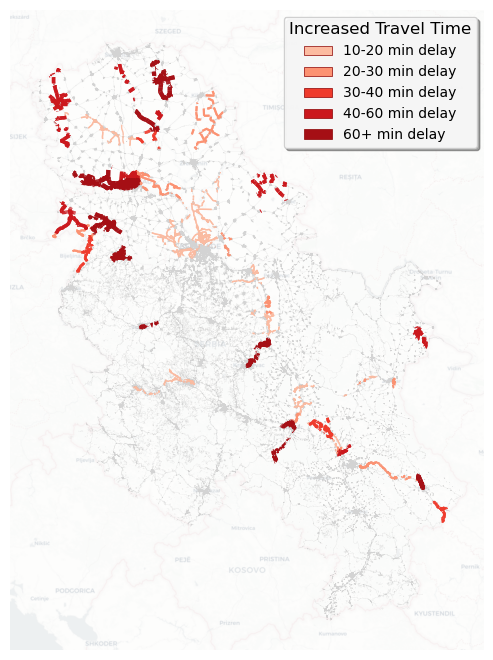

In [25]:
factory_results_path = accessibility_analysis_path / "factory_criticality_results" / "save_new_results_SRB_basins.pkl"
factory_basins = accessibility_analysis_path / "factory_criticality_results" / "unique_scenarios_SRB_basins.pkl"

with open(factory_results_path, 'rb') as file:
    save_new_results = pickle.load(file)

with open(factory_basins, 'rb') as file:
    save_new_basin_results = pickle.load(file)

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('future.no_silent_downcasting', True)
river_basins = list(save_new_results.keys())

collect_removed_edges = []

for basin in river_basins:
    if isinstance(save_new_results[basin]['scenario_outcome'],pd.DataFrame):
        scenario_outcome = save_new_results[basin]['scenario_outcome']
        subset_edges = base_network.loc[base_network.osm_id.astype(str).isin(save_new_results[basin]['real_edges_to_remove'])]
        subset_edges['travel_time_impact'] = scenario_outcome.loc[scenario_outcome.Delta > 0].replace([np.inf, -np.inf], 1).Delta.mean()
    
        collect_removed_edges.append(subset_edges)
exposed_edges = gpd.GeoDataFrame(pd.concat(collect_removed_edges))[['osm_id','from_id', 'to_id','highway','exposed','geometry','travel_time_impact']]

factory_exposed_edges = exposed_edges.loc[exposed_edges.exposed == True].reset_index(drop=True).set_crs(3857,allow_override=True)

# Replace inf with a specific value and nan with 0
factory_exposed_edges['travel_time_impact'] = np.where(
    np.isinf(factory_exposed_edges['travel_time_impact']), 
    1,  # Replace inf with this value
    factory_exposed_edges['travel_time_impact']
)

factory_exposed_edges = factory_exposed_edges.to_crs(3857)

# Filter out everything below 10 minutes (0.167 hours)
factory_exposed_edges = factory_exposed_edges[factory_exposed_edges['travel_time_impact'] >= 0.167].copy().to_crs(3857)

# Define bins for travel time impact - 10-minute increments, ignoring <10 min
# 0.167 hrs = 10 min, 0.333 hrs = 20 min, 0.5 hrs = 30 min, 0.667 hrs = 40 min, 1.0 hrs = 60 min
bins = [0.167, 0.333, 0.5, 0.667, 1.0, np.inf]
labels = ['10-20 min', '20-30 min', '30-40 min', '40-60 min', '60+ min']

legend_elements = []

# Create binned column for travel time impact
factory_exposed_edges['impact_class'] = pd.cut(
    factory_exposed_edges['travel_time_impact'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)

# Create figure with high DPI for crisp visuals
fig, ax = plt.subplots(1, 1, figsize=(20, 8), facecolor='white')

# Create discrete colormap for travel time impact classes
# Using red/orange color scheme - light to dark (low to high impact)
colors = ['#fcbba1', '#fc9272', '#ef3b2c', '#cb181d', '#a50f15']
discrete_cmap = ListedColormap(colors)

# Define line widths for each category (higher impact = thicker lines)
width_mapping = {
    '10-20 min': 1,    # Low impact
    '20-30 min': 1.5,    # Medium-low impact
    '30-40 min': 2.0,    # Medium impact
    '40-60 min': 2.5,    # High impact
    '60+ min': 3       # Very high impact
}

# Plot baseline network first
base_network.plot(ax=ax, linewidth=0.1, color='lightgrey', alpha=0.5)

# Convert to Web Mercator for plotting with basemap
edges_mercator = factory_exposed_edges.to_crs(3857)

# Plot each travel time impact class with different colors and widths
for i, (category, color) in enumerate(zip(labels, colors)):
    category_data = edges_mercator[edges_mercator['impact_class'] == category]
    
    if len(category_data) > 0:
        category_data.plot(
            ax=ax,
            color=color,
            linewidth=width_mapping[category],
            alpha=0.9,
            zorder=5 + i  # Higher impact roads on top
        )

# Add basemap with optimal styling for PNG
cx.add_basemap(
    ax=ax, 
    source=cx.providers.CartoDB.Positron, 
    alpha=0.4,
    attribution=False
)

# Enhance the plot styling
ax.set_aspect('equal')
ax.axis('off')  # Remove axis for cleaner look

# Create custom legend in upper right corner
legend_elements.extend([Patch(facecolor=colors[i], 
                             label=f'{labels[i]} delay', 
                             edgecolor='darkred', 
                             linewidth=0.5) 
                       for i in range(len(labels))])

legend = ax.legend(handles=legend_elements, 
                  title='Increased Travel Time', 
                  loc='upper right',
                  fontsize=10,
                  title_fontsize=12,
                  frameon=True,
                  fancybox=True,
                  shadow=True,
                  framealpha=0.9,
                  facecolor='white',
                  edgecolor='#cccccc')

plt.tight_layout()
plt.subplots_adjust(top=0.88, bottom=0.08, left=0.02, right=0.94)
plt.savefig(figure_path / 'factory_criticality.png', dpi=200, bbox_inches='tight')
plt.show()

plt.close()

In [26]:
# ============================
# 3. Common settings
# ============================
bins = [0.167, 0.333, 0.5, 0.667, 1.0, np.inf]
labels = ['10-20 min', '20-30 min', '30-40 min', '40-60 min', '60+ min']
colors = ['#fcbba1', '#fc9272', '#ef3b2c', '#cb181d', '#a50f15']
width_mapping = {
    '10-20 min': 1.0,
    '20-30 min': 1.5,
    '30-40 min': 2.0,
    '40-60 min': 2.5,
    '60+ min': 3.0
}

# ============================
# 4. Load and process each service
# ============================

def process_service(results_path, basins_path):
    with open(results_path, 'rb') as f:
        save_new_results = pickle.load(f)
    with open(basins_path, 'rb') as f:
        save_new_basin_results = pickle.load(f)

    river_basins = list(save_new_results.keys())
    collect_removed_edges = []

    for basin in river_basins:
        scenario_outcome = save_new_results[basin]['scenario_outcome']
        if isinstance(scenario_outcome, pd.DataFrame):
            subset_edges = base_network.loc[
                base_network.osm_id.astype(str).isin(save_new_results[basin]['real_edges_to_remove'])
            ].copy()
            subset_edges['travel_time_impact'] = scenario_outcome.loc[
                scenario_outcome.Delta > 0
            ].replace([np.inf, -np.inf], 1).Delta.mean()
            collect_removed_edges.append(subset_edges)

    exposed_edges = gpd.GeoDataFrame(pd.concat(collect_removed_edges))[[
        'osm_id','from_id','to_id','highway','exposed','geometry','travel_time_impact'
    ]]

    exposed_edges = exposed_edges.loc[exposed_edges.exposed == True].reset_index(drop=True).set_crs(3857, allow_override=True)
    exposed_edges['travel_time_impact'] = np.where(
        np.isinf(exposed_edges['travel_time_impact']), 1, exposed_edges['travel_time_impact']
    )
    exposed_edges = exposed_edges.to_crs(3857)
    exposed_edges = exposed_edges[exposed_edges['travel_time_impact'] >= 0.167].copy()

    exposed_edges['impact_class'] = pd.cut(
        exposed_edges['travel_time_impact'], bins=bins, labels=labels, include_lowest=True
    )

    return exposed_edges

# Paths for each service
hospital_results_path = accessibility_analysis_path / "healthcare_criticality_results" / "save_new_results_SRB_basins.pkl"
hospital_basins_path = accessibility_analysis_path / "healthcare_criticality_results" / "unique_scenarios_SRB_basins.pkl"

factory_results_path = accessibility_analysis_path / "factory_criticality_results" / "save_new_results_SRB_basins.pkl"
factory_basins_path = accessibility_analysis_path / "factory_criticality_results" / "unique_scenarios_SRB_basins.pkl"

police_results_path = accessibility_analysis_path / "police_criticality_results" / "save_new_results_SRB_basins.pkl"
police_basins_path = accessibility_analysis_path / "police_criticality_results" / "unique_scenarios_SRB_basins.pkl"

fire_results_path = accessibility_analysis_path / "fire_criticality_results" / "save_new_results_SRB_basins.pkl"
fire_basins_path = accessibility_analysis_path / "fire_criticality_results" / "unique_scenarios_SRB_basins.pkl"

# Process all
hospital_exposed_edges = process_service(hospital_results_path, hospital_basins_path)
factory_exposed_edges = process_service(factory_results_path, factory_basins_path)
police_exposed_edges = process_service(police_results_path, police_basins_path)
fire_exposed_edges = process_service(fire_results_path, fire_basins_path)



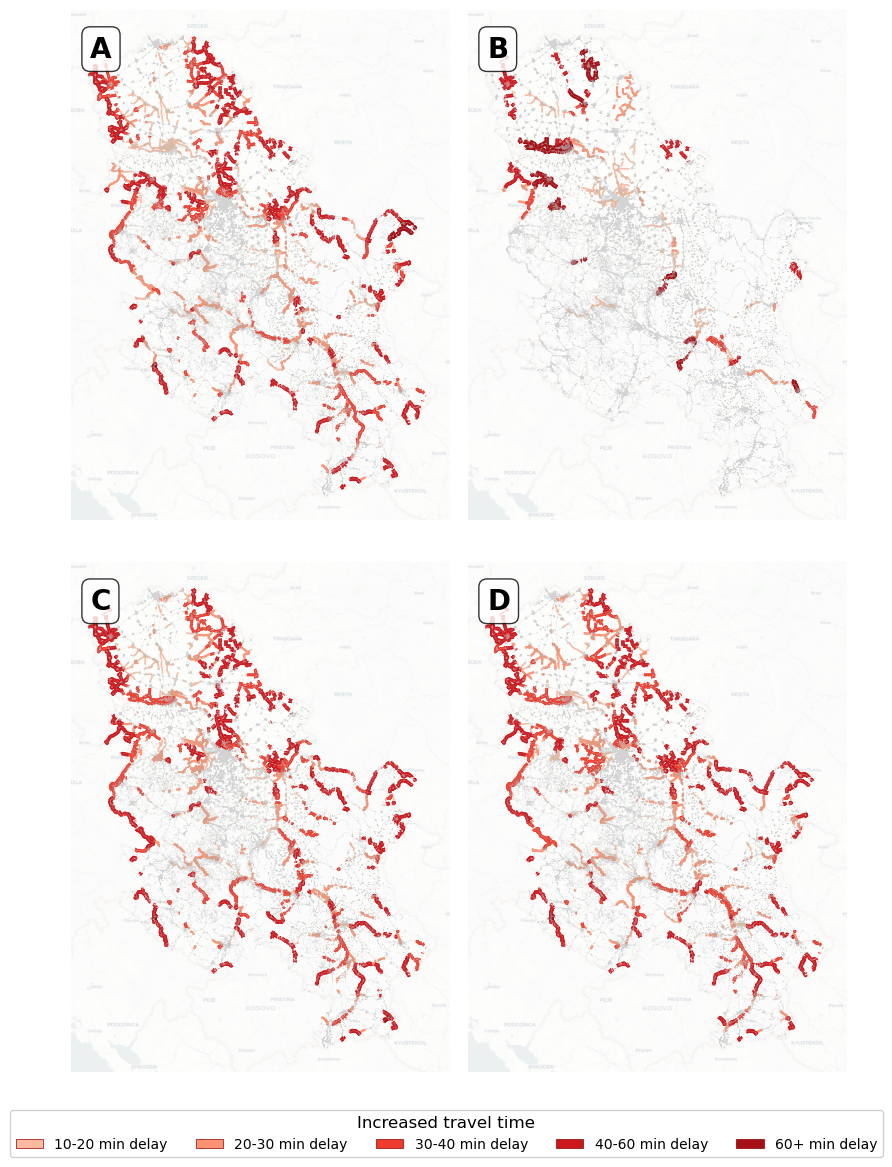

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(10, 14))

def plot_panel(ax, gdf, letter):
    #base_network.plot(ax=ax, linewidth=0.1, color='lightgrey', alpha=0.5)
    for category, color in zip(labels, colors):
        subset = gdf[gdf['impact_class'] == category]
        if len(subset) > 0:
            subset.plot(ax=ax, color=color, linewidth=width_mapping[category], alpha=0.9)
    
    base_network.plot(ax=ax, linewidth=0.1, color='lightgrey', alpha=0.5)

    # ax.set_xlim(*xlim)
    # ax.set_ylim(*ylim)
    ax.axis('off')
    ax.text(0.05, 0.95, letter, transform=ax.transAxes, fontsize=20,
            fontweight='bold', verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron, alpha=0.4, attribution=False)

# Panels
plot_panel(axes[0, 0], hospital_exposed_edges, 'A')  # Hospital
plot_panel(axes[0, 1], factory_exposed_edges, 'B')   # Factory
plot_panel(axes[1, 0], police_exposed_edges, 'C')    # Police
plot_panel(axes[1, 1], fire_exposed_edges, 'D')      # Fire

# Shared legend
legend_handles = [Patch(facecolor=colors[i], label=f'{labels[i]} delay', edgecolor='darkred', linewidth=0.5)
                  for i in range(len(labels))]


fig.legend(
    handles=legend_handles,
    title='Increased travel time',
    loc='lower center',           # anchor point on the legend box
    bbox_to_anchor=(0.5, 0.05),  # (x, y) in figure coordinates
    ncol=len(labels),
    fontsize=10,
    title_fontsize=12,
    frameon=True,
    fancybox=True,
    framealpha=0.9
)

plt.subplots_adjust(wspace=0.05, hspace=0.05)
#plt.tight_layout(rect=[0, 0.06, 1, 1])
plt.savefig(figure_path / "criticality_2x2.png", dpi=150, bbox_inches='tight')
plt.show()


In [28]:
# Uses already prepared GeoDataFrames:
#   hospital_exposed_edges, factory_exposed_edges, police_exposed_edges, fire_exposed_edges
# Each has 'travel_time_impact' in hours, 'impact_class' with labels
#   ['10-20 min','20-30 min','30-40 min','40-60 min','60+ min'], and LineString geometries in EPSG 3857.

import numpy as np
import pandas as pd

# Helper to compute a few compact facts per panel
def panel_facts(gdf):
    if gdf is None or len(gdf) == 0:
        return {
            "mean_min": np.nan,
            "median_min": np.nan,
            "share_60p": 0.0,
            "share_20_60": 0.0,
            "share_10_20": 0.0,
            "total_km": np.nan
        }
    delays_h = gdf["travel_time_impact"].dropna()
    mean_min = float(delays_h.mean() * 60.0)
    median_min = float(delays_h.median() * 60.0)

    # Shares by class
    counts = gdf["impact_class"].value_counts()
    total = counts.sum() if counts.sum() > 0 else 1
    get = lambda k: float(counts.get(k, 0) / total * 100.0)

    share_60p = get("60+ min")
    share_20_60 = get("20-30 min") + get("30-40 min") + get("40-60 min")
    share_10_20 = get("10-20 min")

    # Length in kilometers
    if "geometry" in gdf.columns and gdf.geometry.notna().any():
        total_km = float(gdf.geometry.length.sum() / 1000.0)
    else:
        total_km = np.nan

    return {
        "mean_min": mean_min,
        "median_min": median_min,
        "share_60p": share_60p,
        "share_20_60": share_20_60,
        "share_10_20": share_10_20,
        "total_km": total_km
    }

A = panel_facts(hospital_exposed_edges)  # Figure 20.A
B = panel_facts(factory_exposed_edges)   # Figure 20.B
C = panel_facts(police_exposed_edges)    # Figure 20.C
D = panel_facts(fire_exposed_edges)      # Figure 20.D

# Combined quick facts
frames = [hospital_exposed_edges, factory_exposed_edges, police_exposed_edges, fire_exposed_edges]
frames = [f for f in frames if f is not None and len(f) > 0]
if frames:
    all_delays_h = pd.concat([f["travel_time_impact"] for f in frames]).dropna()
    mean_all_min = float(all_delays_h.mean() * 60.0)
    median_all_min = float(all_delays_h.median() * 60.0)
    total_all_km = float(pd.concat(frames).geometry.length.sum() / 1000.0)
else:
    mean_all_min = np.nan
    median_all_min = np.nan
    total_all_km = np.nan

# Round nicely for readability
def r(x, nd=0):
    return int(round(x)) if nd == 0 and pd.notna(x) else (round(x, nd) if pd.notna(x) else None)

### Save all results for the combined criticality assessment

In [29]:
hospital_exposed_edges.to_parquet(intermediate_path / 'hospital_impacts.parquet')
factory_exposed_edges.to_parquet(intermediate_path / 'factory_impacts.parquet')
police_exposed_edges.to_parquet(intermediate_path / 'police_impacts.parquet')
fire_exposed_edges.to_parquet(intermediate_path / 'fire_impacts.parquet')